# Brain tumor
Analiza i klasifikacija MRI slika

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import seaborn as sns
import random
import shutil
import imutils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

Slike se nalaze u folderu "brain_tumor_dataset"

In [4]:
input_path = 'brain_tumor_dataset'

Postoji folder za MRI slike koje pokazuju tumor - `yes` i za one koje ne pokazuju tumor -`no`

In [5]:
for file in os.listdir(input_path):
    print(file)

no
yes


<AxesSubplot:>

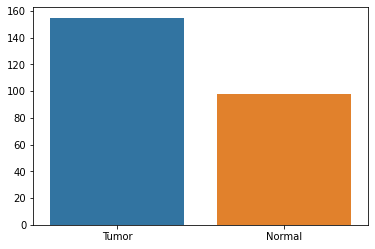

In [6]:
noTumor = len(os.listdir(input_path + '/no'))
yesTumor = len(os.listdir(input_path + '/yes'))

count = [yesTumor, noTumor]
label=['Tumor','Normal']

sns.barplot(label,count)

In [7]:
noTumor

98

In [8]:
yesTumor

155

Imamo 155 slika koje pokazuju tumor i 98 koje ne pokazuju tumor

In [9]:
def show_image(dir_path, folder, num):
    path = os.path.join(dir_path, folder)
    
    images = random.choices(os.listdir(path), k = num)
    images = [os.path.join(path, file) for file in images]
    
    return images

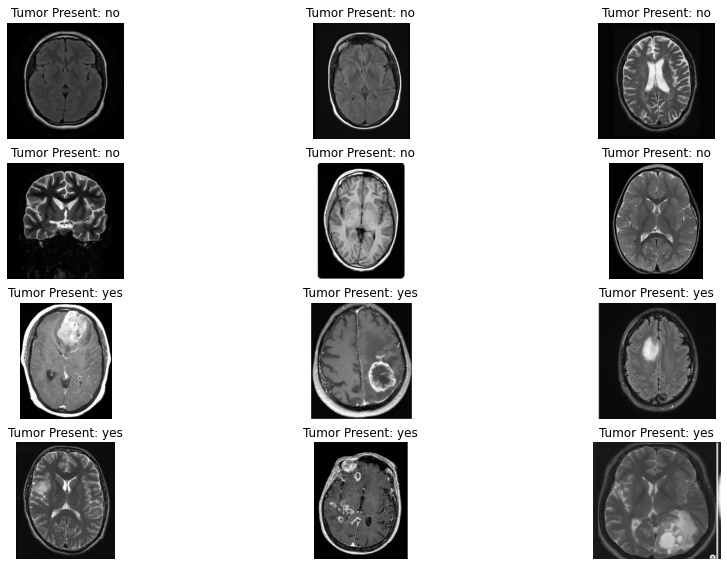

In [10]:
img1 = show_image(input_path, 'no', 6)
img2 = show_image(input_path, 'yes', 6)
label1 = ['no']*6
label2 = ['yes']*6

images = img1 + img2
labels = label1 + label2

plt.figure(figsize=(15,15))

for i,path_name in enumerate(images):
    plt.subplot(6,3,i+1)
    image = cv.imread(path_name)
    plt.imshow(image)
    plt.title("Tumor Present: " + labels[i])
    plt.axis('off')

## Priprema podataka

In [23]:
def load_data(dir_list):
    X = []
    y = []
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv.imread(directory + '/' + filename)

            X.append(image)
            # append a value of 1 to the y array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data (improves the model)
    X, y = shuffle(X, y)
    
    return X, y

Za veliki broj slika možemo odseći deo slike gde koji zauzima samo crna površina.

In [12]:
def crop_image(img, add_pixels_value=0, plot=False):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    gray = cv.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv.threshold(gray, 45, 255, cv.THRESH_BINARY)[1]
    thresh = cv.erode(thresh, None, iterations=2)
    thresh = cv.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1] + ADD_PIXELS, extLeft[0]- ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_img)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_img

Primer slike:

In [13]:
img_test = cv.imread('brain_tumor_dataset/yes/Y29.jpg')
img_test = cv.resize(
            img_test,
            dsize=(224,224),
            interpolation=cv.INTER_CUBIC)

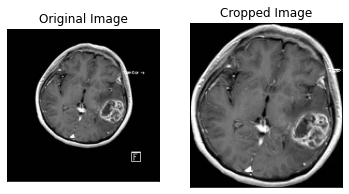

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [14]:
crop_image(img_test,0,True)

In [15]:
def Croping_Data(images):
    X = []
    
    for img in images:
        image = crop_image(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    
    return X

In [103]:
#load data
X_train_crop, y_train_crop = load_data([input_path + '/yes', input_path + '/no'])

In [104]:
#crop images
X_crop = Croping_Data(X_train_crop)

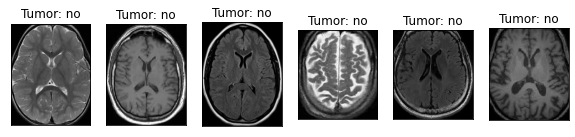

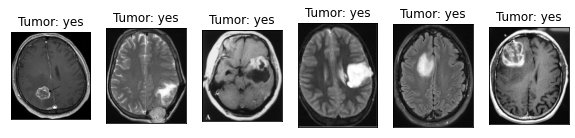

In [27]:
for index in range(len(['no','yes'])):
    imgs = X_crop[np.argwhere(y_train_crop == index)][:6]
    j = 6
    i = 1
   
    plt.figure(figsize=(10,10))
    c = 1
    for img in imgs:
        plt.subplot(i,j,c)
        plt.imshow(img[0])

        plt.xticks([])
        plt.yticks([])
        c += 1
        plt.title('Tumor: {}'.format(['no','yes'][index]))
    plt.show()

Sada trebamo sačuvati ove slike:

In [105]:
os.makedirs('output/cropped-images', exist_ok = True)
os.makedirs('output/cropped-images/yes', exist_ok = True)
os.makedirs('output/cropped-images/no', exist_ok = True)

cropped_data_path = 'output/cropped-images'

In [29]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv.imwrite(folder_name+'/no/'+ str(i) + 'no.jpg', img)
        else:
            cv.imwrite(folder_name+'/yes/'+ str(i) + 'yes.jpg', img)
        i += 1

In [106]:
dir = os.listdir('output/cropped-images/yes') 
#if folder doesn't exists
if len(dir) == 0:
    save_new_images(X_crop, y_train_crop, folder_name = cropped_data_path)
else:
    print(len(dir))

Pošto je broj slika mali, možemo povećati broj slika tako što ćemo primeniti slučajne transformacije nad njima kao što su slučajna horizontalna okretanja ili male slučajne rotacije

Novi folder za smeštanje slika:

In [31]:
os.makedirs('output/augmented-images', exist_ok = True)
os.makedirs('output/augmented-images/yes', exist_ok = True)
os.makedirs('output/augmented-images/no', exist_ok = True)

augmented_data_path = 'output/augmented-images'

In [32]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in os.listdir(file_dir):
        image = cv.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [33]:
dir = os.listdir('output/augmented-images/yes') 
#if folder doesn't exists
if len(dir) == 0: 
    # augment data in cropped images folder 'yes'
    augment_data(file_dir = cropped_data_path + '/yes', n_generated_samples = 6, save_to_dir = augmented_data_path + '/yes')
    # augment data in cropped images folder 'no' 
    augment_data(file_dir = cropped_data_path +'/no', n_generated_samples = 9, save_to_dir = augmented_data_path + '/no')
else:
    print(len(dir))

1085


In [35]:
augmented_yes = augmented_data_path +'/yes'
augmented_no = augmented_data_path +'/no'

Učitavanje obrađenih slika:

In [36]:
X_train, y_train = load_data([augmented_yes, augmented_no])

In [37]:
y_train.size

2064

In [38]:
X_train.size

2064

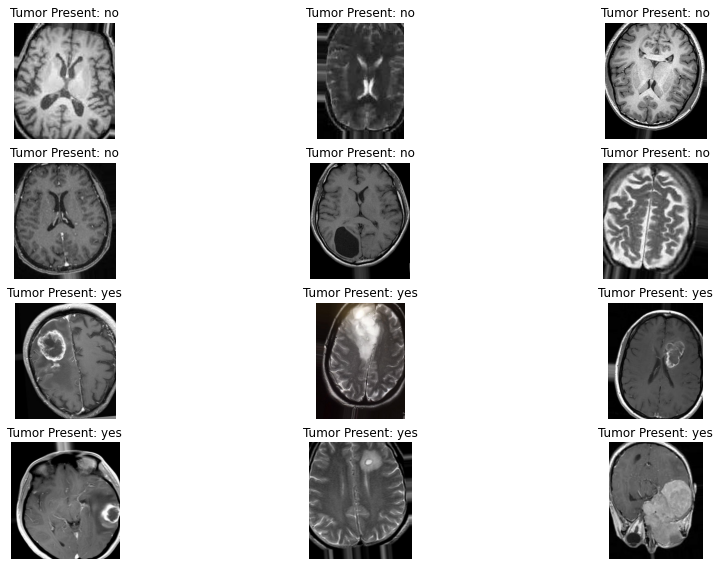

In [39]:
img1 = show_image(augmented_data_path, 'no', 6)
img2 = show_image(augmented_data_path, 'yes', 6)
label1 = ['no']*6
label2 = ['yes']*6

images = img1 + img2
labels = label1 + label2

plt.figure(figsize=(15,15))

for i,path_name in enumerate(images):
    plt.subplot(6,3,i+1)
    image = cv.imread(path_name)
    plt.imshow(image)
    plt.title("Tumor Present: " + labels[i])
    plt.axis('off')

Sada ovako obrađenim slikama možemo trenirati neuronsku mrežu

## Treniranje mreže

In [40]:
def Resize_Data(train):
    X = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_CUBIC)
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    
    return X

Dataset delimo na 3 podskupa, `train`, `test` i `validation`. validation podskup se koristi za podešavanje parametra, a `test` za evaluaciju performansi modela.

In [41]:
def split_data(X, y):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.3, random_state = 42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [42]:
X = Resize_Data(X_train)
y = y_train

In [43]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [44]:
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_val.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))

Number of training examples = 1444
Number of validation examples = 310
Number of test examples = 310


In [45]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [46]:
IMG_SHAPE = (240, 240, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)       

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
46/46 [==============================] - 92s 2s/step - loss: 0.8791 - accuracy: 0.5956 - val_loss: 0.7457 - val_accuracy: 0.4742
Epoch 2/25
46/46 [==============================] - 91s 2s/step - loss: 0.6093 - accuracy: 0.6918 - val_loss: 0.6744 - val_accuracy: 0.5677
Epoch 3/25
46/46 [==============================] - 93s 2s/step - loss: 0.5710 - accuracy: 0.7001 - val_loss: 0.6617 - val_accuracy: 0.6129
Epoch 4/25
46/46 [==============================] - 98s 2s/step - loss: 0.6396 - accuracy: 0.6891 - val_loss: 0.8344 - val_accuracy: 0.5226
Epoch 5/25
46/46 [==============================] - 91s 2s/step - loss: 0.5197 - accuracy: 0.7452 - val_loss: 0.6678 - val_accuracy: 0.6000
Epoch 6/25
46/46 [==============================] - 90s 2s/step - loss: 0.4980 - accuracy: 0.7604 - val_loss: 0.5751 - val_accuracy: 0.6968
Epoch 7/25
46/46 [==============================] - 92s 2s/step - loss: 0.5213 - accuracy: 0.7555 - val_loss: 0.7605 - val_accuracy: 0.5968
Epoch 8/25
46/46 [==

In [48]:
history = model.history.history

In [49]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

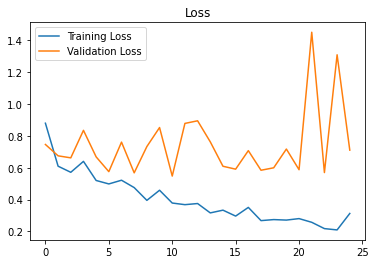

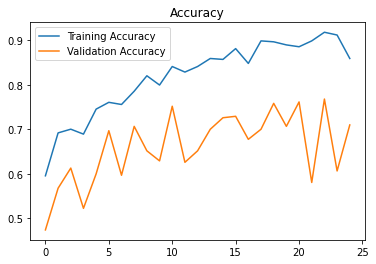

In [50]:
plot_metrics(history)

In [51]:
import itertools

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Val Accuracy = 0.71


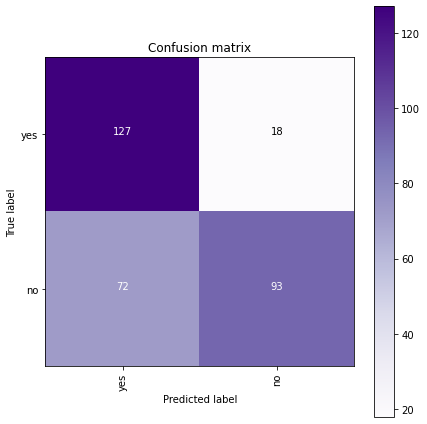

In [53]:
labels = ['yes','no']
# validation set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

Val Accuracy = 0.74


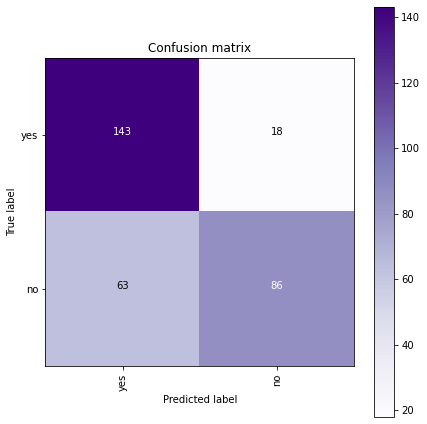

In [54]:
# test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

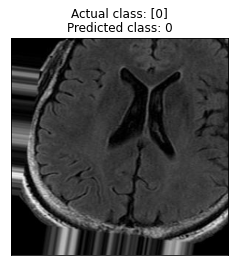

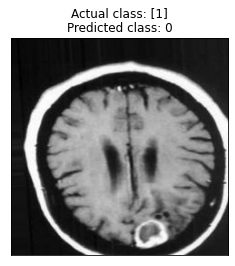

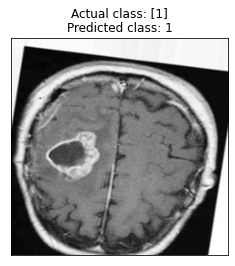

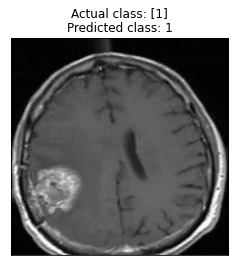

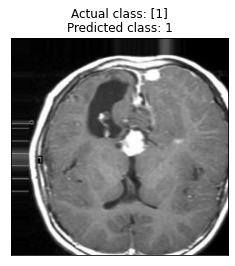

In [55]:
for i in range(5):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

## VGG16

Isečene slike raspoređujemo u tri foldera, `train`, `test` i `validation`.

In [107]:
os.makedirs('output/vgg16-images', exist_ok = True)

os.makedirs('output/vgg16-images/train/yes', exist_ok = True)
os.makedirs('output/vgg16-images/train/no', exist_ok = True)
os.makedirs('output/vgg16-images/test/yes', exist_ok = True)
os.makedirs('output/vgg16-images/test/no', exist_ok = True)
os.makedirs('output/vgg16-images/val/yes', exist_ok = True)
os.makedirs('output/vgg16-images/val/no', exist_ok = True)

In [109]:
for CLASS in os.listdir(cropped_data_path):
    IMG_NUM = len(os.listdir(cropped_data_path + '/' + CLASS))
    for (n, FILE_NAME) in enumerate(os.listdir(cropped_data_path + '/' + CLASS)):
        img = cropped_data_path + '/' + CLASS + '/' + FILE_NAME
        if n < 15:
            shutil.copy(img, 'output/vgg16-images/test/' + CLASS.lower() + '/' + FILE_NAME)
        elif n < 0.8*IMG_NUM:
            shutil.copy(img, 'output/vgg16-images/train/'+ CLASS.lower() + '/' + FILE_NAME)
        else:
            shutil.copy(img, 'output/vgg16-images/val/'+ CLASS.lower() + '/' + FILE_NAME)

In [97]:
vgg16_data_path = 'output/vgg16-images'

In [110]:
#load data
X_train, y_train = load_data([vgg16_data_path + '/train/yes', vgg16_data_path + '/train/no'])
X_test, y_test = load_data([vgg16_data_path + '/test/yes', vgg16_data_path + '/test/no'])
X_val, y_val = load_data([vgg16_data_path + '/val/yes', vgg16_data_path + '/val/no'])

Za korišćenje VGG-16 modela moramo preprocesirati slike.

In [114]:
def preprocess_imgs(set_name, img_size):
    #Resize and apply VGG-16 preprocessing
    set_new = []
    for img in set_name:
        img = cv.resize(
            img,
            dsize=img_size,
            interpolation=cv.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [115]:
IMG_SIZE = (224,224)
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

In [153]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
    vgg16_data_path + '/train',
    target_size=IMG_SIZE,
    class_mode='binary'
)


validation_generator = test_datagen.flow_from_directory(
    vgg16_data_path + '/val',
    target_size=IMG_SIZE,
    class_mode='binary'
)

Found 173 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Učitavanje VGG16 modela:

In [148]:
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg_model=VGG16(weights=vgg16_weight_path, input_shape=(224,224,3), include_top=False)
model=keras.Sequential()
model.add(vgg_model)

In [149]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [150]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [154]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30
6/6 [==============================] - 34s 6s/step - loss: 1.5501 - accuracy: 0.8786 - val_loss: 1.5730 - val_accuracy: 0.9000
Epoch 2/30
6/6 [==============================] - 46s 8s/step - loss: 1.6321 - accuracy: 0.8786 - val_loss: 2.4933 - val_accuracy: 0.8600
Epoch 3/30
6/6 [==============================] - 40s 7s/step - loss: 2.1890 - accuracy: 0.8613 - val_loss: 1.0131 - val_accuracy: 0.9000
Epoch 4/30
6/6 [==============================] - 40s 7s/step - loss: 1.6647 - accuracy: 0.8960 - val_loss: 1.9116 - val_accuracy: 0.8400
Epoch 5/30
6/6 [==============================] - 43s 7s/step - loss: 1.1671 - accuracy: 0.9133 - val_loss: 2.8420 - val_accuracy: 0.8600
Epoch 6/30
6/6 [==============================] - 42s 7s/step - loss: 0.9318 - accuracy: 0.9249 - val_loss: 3.3258 - val_accuracy: 0.8600
Epoch 7/30
6/6 [==============================] - 44s 7s/step - loss: 0.8725 - accuracy: 0.9306 - val_loss: 2.4955 - val_accuracy: 0.8600
Epoch 8/30
6/6 [==================

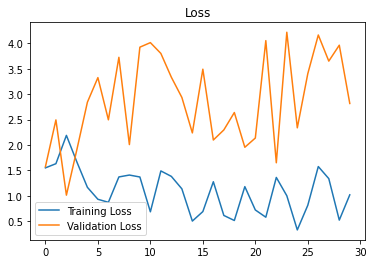

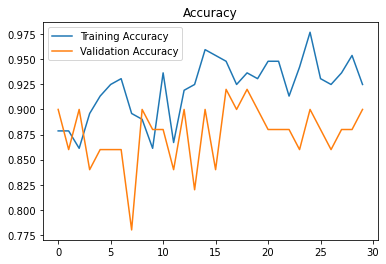

In [155]:
plot_metrics(history.history)

Val Accuracy = 0.94


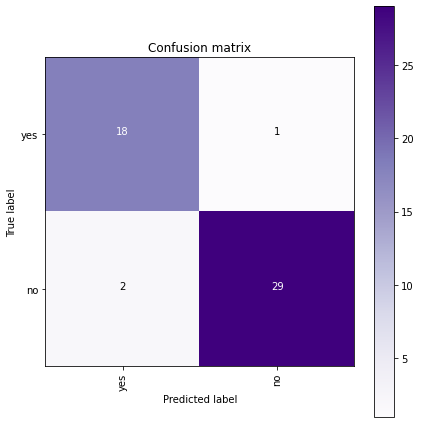

In [157]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

Test Accuracy = 0.83


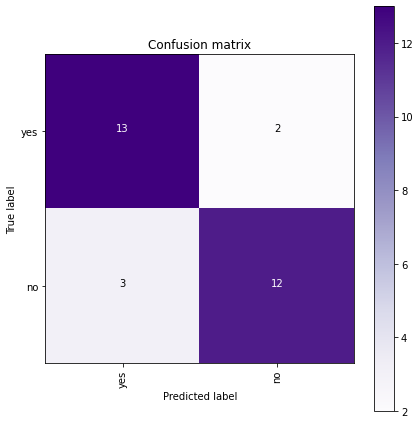

In [158]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

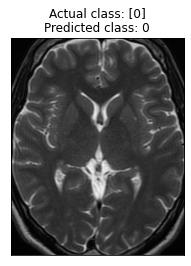

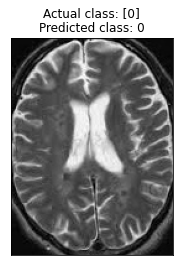

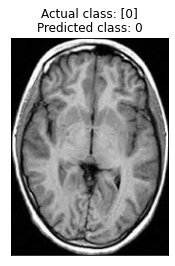

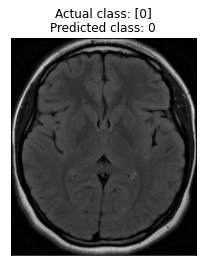

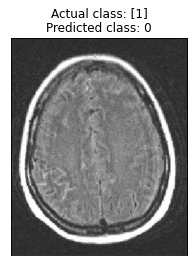

In [161]:
for i in range(5,10):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

VGG16 model se pokazao bolje od prvog modela.